# Import

In [4]:
# import libraries
# python staples
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
# scikitlearn

from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

# use matplot |in jupyter notebook
#%matplotlib inline

/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Functions

In [34]:
def clean_data( mydata, drop_list, verbose ):
    # some data is pointless, get rid of id
    mydata = mydata.drop( drop_list, axis=1 )
    if "Embarked" in mydata:
        embark_df=pd.get_dummies(mydata.Embarked,prefix='embark')
        mydata=mydata.join(embark_df)
        mydata=mydata.drop('Embarked',axis=1)
    if "Cabin" in mydata:
        mydata.Cabin = mydata.Cabin.fillna('N')
        mydata.Cabin = mydata.Cabin.apply(lambda y: y[0])
        cabin_df=pd.get_dummies(mydata.Cabin,prefix='deck')
        mydata = mydata.join(cabin_df)
        mydata=mydata.drop('Cabin',axis=1)
    #if (mydata):
    #mydata.Cabin = mydata.Cabin.fillna('N')
    #mydata.Cabin = mydata.Cabin.apply(lambda y: y[0])
    
    # clean it
    # find isnan value
    if verbose == 1:
        print( 'before clean isnan check:\n', mydata.isna().any() )
    # turn male/female, embarked to a number
    mydata.loc[mydata.Sex == 'female','Sex' ] = 0
    mydata.loc[mydata.Sex == 'male','Sex' ] = 1
    #mydata.loc[mydata.Embarked == 'S','Embarked' ] = 0
    #mydata.loc[mydata.Embarked == 'C','Embarked' ] = 1
    #mydata.loc[mydata.Embarked == 'Q','Embarked' ] = 2
    # replace nan with average
    mydata.loc[mydata.Age.isnull(),'Age']  = np.mean( mydata.Age[~mydata.Age.isna()] )
    mydata.loc[mydata.Fare.isnull(),'Fare']  = np.mean( mydata.Fare[~mydata.Fare.isna()] )
    #mydata.loc[mydata.Embarked.isna(),'Embarked'] = mydata.mode().Embarked[0]
    #normalize
    mydata.Age = ( mydata.Age - mydata.Age.mean() ) / mydata.Age.std()
    mydata.Fare = ( mydata.Fare - mydata.Fare.mean() ) / mydata.Fare.std()
    if verbose:
        print('after clean isnan check:\n', mydata.isna().any() )
        print( 'Cleaned data:', mydata.iloc[0] )
    return mydata

def sklearn_fit( fitmodel, x_train, y_train, x_cv, y_cv, verbose ):
    fitmodel.fit(x_train, y_train)
    prediction = fitmodel.predict(x_cv)
    accuracy = get_accuracy( y_cv, prediction )
    model = {'prediction': prediction, 'accuracy': accuracy }
    return model

def get_accuracy( y_actual, y_pred ):
    return np.sum( y_actual == y_pred) / np.size( y_actual)

def get_rand_train_inds( num_points, train_frac ):
        num_train = np.round( num_tot * train_frac )
        ind_all = np.arange(num_points)
        ind_train = np.random.choice(int(num_points), int(num_train), replace=False)
        ind_cv = np.delete( ind_all, ind_train )
        return ind_train, ind_cv

# Mike's analysis

## Grab data and get a preview

In [35]:
# grab the data and put it in a pandas dataframe
df_train_all = pd.read_csv('train.csv')
df_test_all = pd.read_csv('test.csv')
# print some info
print('Original train data set:\n\n', df_train_all.iloc[0])
print('Original test data set:\n\n', df_test_all.iloc[0])
num_features = len( df_train_all.columns ) - 1
print('\n features:', num_features )

Original train data set:

 PassengerId                          1
Survived                             0
Pclass                               3
Name           Braund, Mr. Owen Harris
Sex                               male
Age                                 22
SibSp                                1
Parch                                0
Ticket                       A/5 21171
Fare                              7.25
Cabin                              NaN
Embarked                             S
Name: 0, dtype: object
Original test data set:

 PassengerId                 892
Pclass                        3
Name           Kelly, Mr. James
Sex                        male
Age                        34.5
SibSp                         0
Parch                         0
Ticket                   330911
Fare                     7.8292
Cabin                       NaN
Embarked                      Q
Name: 0, dtype: object

 features: 11


## Clean data

In [36]:
# clean data
#drop_list = ['PassengerId','Name','Ticket', 'Cabin']
drop_list = ['PassengerId','Name','Ticket', 'Cabin']
# break the y data to train, validation set
train_frac = 0.66;
num_tot = len( df_train_all.index)

# clean it
y_train = df_train_all.Survived
df_data = clean_data( df_train_all, drop_list, 0)
# separate into training/test sets
x_train = df_data.drop( 'Survived', axis=1 )
x_test = clean_data( df_test_all, drop_list, 0)
# print some info
num_features_test = len( x_test.columns )
num_features_train = len( x_train.columns )
print( 'Data set:\n', x_train.iloc[0])
print( 'Data set:\n', x_test.iloc[0])

Data set:
 Pclass      3.000000
Sex         1.000000
Age        -0.592148
SibSp       1.000000
Parch       0.000000
Fare       -0.502163
embark_C    0.000000
embark_Q    0.000000
embark_S    1.000000
Name: 0, dtype: float64
Data set:
 Pclass      3.000000
Sex         1.000000
Age         0.334592
SibSp       0.000000
Parch       0.000000
Fare       -0.497811
embark_C    0.000000
embark_Q    1.000000
embark_S    0.000000
Name: 0, dtype: float64


## Plotting


### Correlation plot

<Figure size 2880x2880 with 0 Axes>

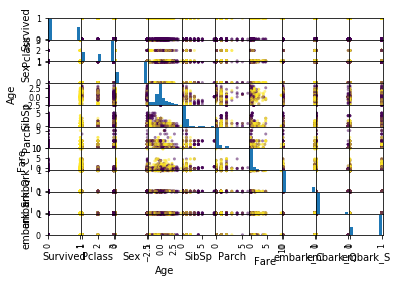

In [37]:
plt.figure(figsize=(40,40))
pd.plotting.scatter_matrix(df_data,c=df_data.Survived)
plt.show()

### PCA

Text(0.5,1,'PCA')

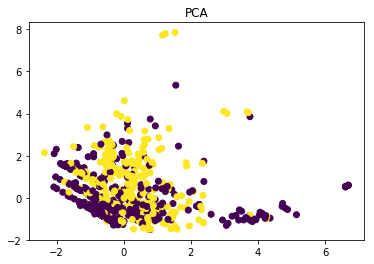

In [38]:
# Principal component analysis
# 2d
pca2 = PCA(n_components=2)
pca2.fit(x_train)
x_transform2 = pca2.transform(x_train)
plt.scatter( x_transform2[:,0], x_transform2[:,1], c = y_train )
plt.title('PCA')

## Fitting

### Stat models logistic

See what parameters are relevant

In [39]:
# Logistical fit using sm.Logit
logistic = sm.Logit(y_train, x_train)
# fit the model
result = logistic.fit()
print( result.summary2() )


Optimization terminated successfully.
         Current function value: 0.444359
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.333     
Dependent Variable: Survived         AIC:              809.8473  
Date:               2018-04-06 22:33 BIC:              852.9784  
No. Observations:   891              Log-Likelihood:   -395.92   
Df Model:           8                LL-Null:          -593.33   
Df Residuals:       882              LLR p-value:      2.4160e-80
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Pclass       -1.0379    0.1420   -7.3114  0.0000  -1.3161  -0.7596
Sex          -2.7053    0.1996  -13.5531  0.0000  -3.0965  -2.

## Fit over sklearn models

In [40]:
# fit them all
verbose = 0
# sci-kit learn logistic regression
logistic = linear_model.LogisticRegression()
# linear discriminant analysis
lda = LinearDiscriminantAnalysis()
# SVM: linear kernal
linear_svc = SVC(kernel='linear')
# SVM: gaussian kernal
gaussian_svc = SVC(kernel='rbf')
# random forest
randfor = RandomForestClassifier(max_depth=2, random_state=0)
# knn 
n_neighbors = 12
knn = KNeighborsClassifier(n_neighbors)
# build a list
list_o_fits = [logistic, lda, linear_svc, gaussian_svc, randfor, knn]

In [42]:
# try this over many random sets of the data
num_trials = 10
accuracy_mat = np.zeros( (num_trials, len(list_o_fits) ))
for i in range(num_trials):
    # separate into training sets
    ind_train, ind_cv = get_rand_train_inds( num_tot, train_frac )
    x_train_temp = x_train.iloc[ind_train]
    x_cv_temp = x_train.iloc[ind_cv]
    y_train_temp = y_train.iloc[ind_train]
    y_cv_temp = y_train.iloc[ind_cv]
    # fit
    fit_results = [ sklearn_fit(a_fit, x_train_temp, y_train_temp, 
                                x_cv_temp, y_cv_temp, verbose) 
                   for a_fit in list_o_fits]
    accuracy_mat[i,:] = np.array( [a_fit["accuracy"] for a_fit in fit_results] );


/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [43]:
# average for the best
mean_accuracy = accuracy_mat.mean(axis=0)
bestmodelid=mean_accuracy.argmax()
std_accuracy = accuracy_mat.std(axis=0)
best_model = {'accuracy': mean_accuracy[bestmodelid],
              'std':std_accuracy[bestmodelid],
              'list_ind': bestmodelid, 
              'class_name': list_o_fits[bestmodelid].__class__ };
print( best_model )

{'accuracy': 0.8158415841584159, 'list_ind': 3, 'class_name': <class 'sklearn.svm.classes.SVC'>, 'std': 0.01429465863215029}


# Jeff's Analysis